In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Confidence in hypothesis

This notebook demonsrtrates the evolution of confidence in a hypothesis. Depending on the hypothesis configuration of a subgraph we compare it to the maximum confidence we can obtain from a bigger graph.

## Statistics of the hypothesis graph

Number of nodes and arcs of the hypothesis graph

In [3]:
from hypotest.setup_hypothgraph import sample_graphs

INFO:rdflib:RDFLib Version: 4.2.1


In [4]:
hypothgraph = sample_graphs.sample_hypothgraph()

In [5]:
nb_nodes = len(hypothgraph.nodes())
nb_arcs = len(hypothgraph.edges())

In [6]:
print("number of nodes {}, number of arcs {}".format(nb_nodes, nb_arcs))

number of nodes 28, number of arcs 45


## Hypothesis causal endpoints

Creation of a subgraph is a bit of *woodo* magic, we need to say what is the desired ratio of the paths from *source* to *target*, the causal endpoints of a hypothesis. So before we proceed we need the hypothesis configuration.

In [7]:
import networkx as nx

In [8]:
from hypotest.graph_generation import hypoth_conf

In [9]:
source, target = hypoth_conf.generate_rich_endpoints(hypothgraph, min_nb_paths=6)

In [10]:
print('number of paths from {} to {} is {}'.format(source, target, len(list(nx.all_simple_paths(hypothgraph, source, target)))))

number of paths from http://plumdeq.xyz/ontologies/hypothesis/Biochemical_imbalance to http://plumdeq.xyz/ontologies/hypothesis/Knee_pain is 6


In [11]:
conf = hypoth_conf.Hypoth_Conf(source, target, [])

## Create a sub hypothesis graph

We deliberately choose a very small ratio of `on_boundary` paths, however we take some fair amount of paths within the hypothesis configuration.

In [12]:
from hypotest.graph_generation import sub_hypothgraph

In [13]:
ratio_on_boundary_paths = 0.01
ratio_endpoints_paths = 0.1

In [14]:
subgraph = sub_hypothgraph.generate_sub_hypothgraph(
    hypothgraph, source, target,
    ratio_endpoints_paths=ratio_endpoints_paths,
    ratio_on_boundary_paths=ratio_on_boundary_paths)

In [15]:
nb_sub_nodes = len(subgraph.nodes())
nb_sub_arcs = len(subgraph.edges())

In [16]:
print("number of nodes {}, number of arcs {}".format(nb_sub_nodes, nb_sub_arcs))

number of nodes 20, number of arcs 29


## Computing confidences

To compute the confidences in both sub and hypothgraphs we need to determine what are boundary interiors in both of the graphs.

### Confidence computation

Confidence is computed as the sum of all weighted paths from `source` to `target` normalized to the number of these weighted paths. Suppose `source` is $u$ and `target` is $v$.

$$
Confidence(u, v) = \frac{\sum_{\pi_i(u, v)} weighted\_path(\pi_i)}{len(\pi(u, v))}
$$

### Boundary interiors of the two graphs

In [17]:
from hypotest.graph_generation import boundary

In [18]:
sub_boundary_interior = list(boundary.in_boundary_interior(subgraph, source, target))

In [19]:
big_boundary_interior = list(boundary.in_boundary_interior(hypothgraph, source, target))

In [20]:
print("Nb nodes in the boundary interior (subgraph) {}), nb nodes in full boundary interior {}".format(
    len(sub_boundary_interior), len(big_boundary_interior)))

Nb nodes in the boundary interior (subgraph) 6), nb nodes in full boundary interior 7


In [21]:
big_nb_paths = len(list(nx.all_simple_paths(hypothgraph, source, target)))
small_nb_paths = len(list(nx.all_simple_paths(subgraph, source, target)))
print("Nb of paths in big {} and in small {}".format(big_nb_paths, small_nb_paths))

Nb of paths in big 6 and in small 4


### Confidence subgraph

In [22]:
from hypotest.stats import confidences

Confidence in the hypothesis as we gradually add more evidenced nodes from the boundary, inside the subgraph only

In [23]:
sub_confidences = confidences.confidence_spectrum(subgraph, source, target)
sub_confidences

[0.0, 4.0, 6.0, 10.0, 14.0, 16.0, 20.0]

In [24]:
sub_confidences_normalized = confidences.confidence_spectrum(subgraph, source, target, normalized=True)
sub_confidences_normalized

[0.0, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0]

### Plot subgraph confidence related values

In [25]:
import os
path_to_figures = './images/subgraphs'

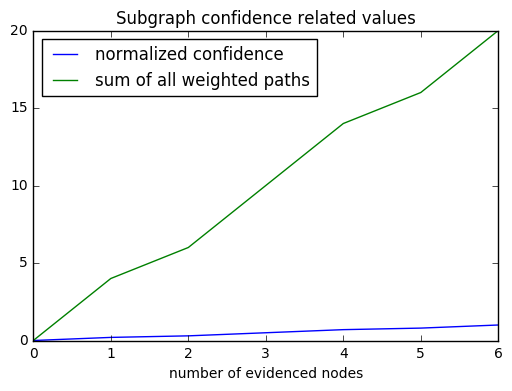

In [26]:
subgraph_fig = plt.figure('1')
plt.subplot('111')
plt.plot(sub_confidences_normalized, label='normalized confidence')
plt.plot(sub_confidences, label='sum of all weighted paths')
plt.xlabel('number of evidenced nodes')
plt.legend(loc='upper left')
plt.title('Subgraph confidence related values')

Draw the figure with sub graph statistics

In [27]:
# Make the first figure active
subgraph_plot_png = os.path.abspath(os.path.join(path_to_figures, 'subgraph_plot.png'))
subgraph_fig.savefig(subgraph_plot_png)

### Confidence bigraph 

In [28]:
big_confidences = confidences.confidence_spectrum(hypothgraph, source, target)
big_confidences

[0.0, 2.0, 8.0, 10.0, 16.0, 22.0, 25.0, 31.0]

In [29]:
big_confidences_normalized = confidences.confidence_spectrum(hypothgraph, source, target, normalized=True)
big_confidences_normalized

[0.0,
 0.06451612903225806,
 0.25806451612903225,
 0.3225806451612903,
 0.5161290322580645,
 0.7096774193548387,
 0.8064516129032258,
 1.0]

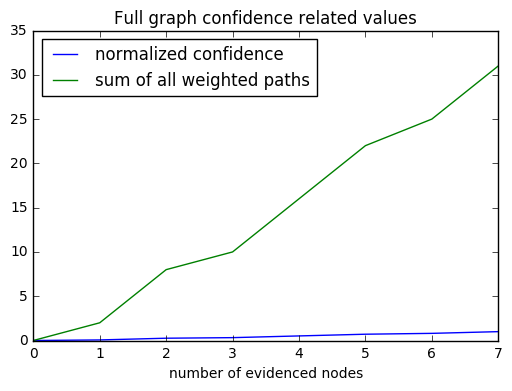

In [30]:
biggraph_fig = plt.figure('2')
plt.subplot('111')
plt.plot(big_confidences_normalized, label='normalized confidence')
plt.plot(big_confidences, label='sum of all weighted paths')
plt.xlabel('number of evidenced nodes')
plt.legend(loc='upper left')
plt.title('Full graph confidence related values')

In [31]:
# Make the first figure active
biggraph_plot_png = os.path.abspath(os.path.join(path_to_figures, 'bigraph_plot.png'))
biggraph_fig.savefig(biggraph_plot_png)

## Relative confidence values

Here we check confidence values which can be obtained withing the small graph, normalized to the max confidence inside the small graph, as well as normalized to the max in the big graph

In [32]:
import pandas as pd

In [33]:
relative_spectrum = confidences.relative_confidence_spectrum(hypothgraph, subgraph, source, target)

In [34]:
relative_spectrum_df = pd.DataFrame(relative_spectrum)

In [35]:
relative_spectrum_df

,big_confidence_normalized_spectrum,big_confidence_spectrum,sub_confidence_normalized_spectrum,sub_confidence_spectrum
0,0.000000,0.0,0.0,0.0
1,0.193548,6.0,0.2,4.0
2,0.258065,8.0,0.3,6.0
3,0.451613,14.0,0.5,10.0
4,0.645161,20.0,0.7,14.0
5,0.741935,23.0,0.8,16.0
6,0.935484,29.0,1.0,20.0


### Plot relative confidence values

We plot relative normalized confidences

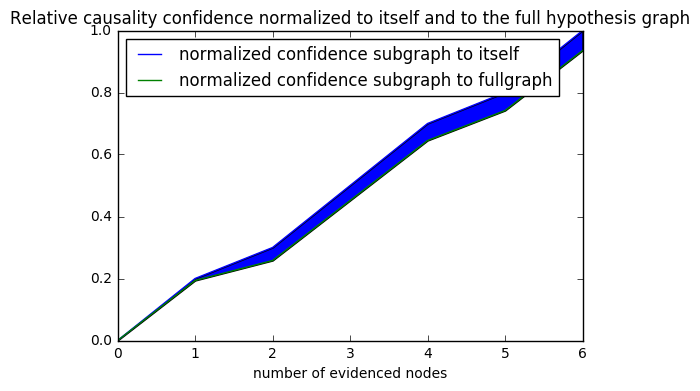

In [36]:
relative_confidence_fig = plt.figure('3')
plt.subplot('111')
x = range(len(relative_spectrum_df['sub_confidence_normalized_spectrum']))
plt.plot(relative_spectrum_df['sub_confidence_normalized_spectrum'], 
         label='normalized confidence subgraph to itself')
plt.plot(relative_spectrum_df['big_confidence_normalized_spectrum'], 
         label='normalized confidence subgraph to fullgraph',
         fillstyle='bottom')
# show relative delta between the two
plt.fill_between(x=x, y1=relative_spectrum_df['sub_confidence_normalized_spectrum'],
                 y2=relative_spectrum_df['big_confidence_normalized_spectrum'])
plt.xlabel('number of evidenced nodes')
plt.legend(loc='upper left')
plt.title('Relative causality confidence normalized to itself and to the full hypothesis graph')

In [37]:
# Make the first figure active
relative_confidence_plot_png = os.path.abspath(os.path.join(path_to_figures, 'relative_plot.png'))
relative_confidence_fig.savefig(relative_confidence_plot_png)

## Draw this configuration

In [38]:
from hypotest.io import write_dot

In [39]:
from IPython.display import Image

### Draw subgraph, by including positions of the nodes of the big graph

In [40]:
small_dot = os.path.join(path_to_figures, 'small.dot')
small_png = os.path.join(path_to_figures, 'small.png')

with open(small_dot, 'w') as f:
    write_dot.hypothgraph_with_invisible_to_dot(hypothgraph, subgraph, conf, stream=f)

In [41]:
!dot -Tpng -o $small_png $small_dot

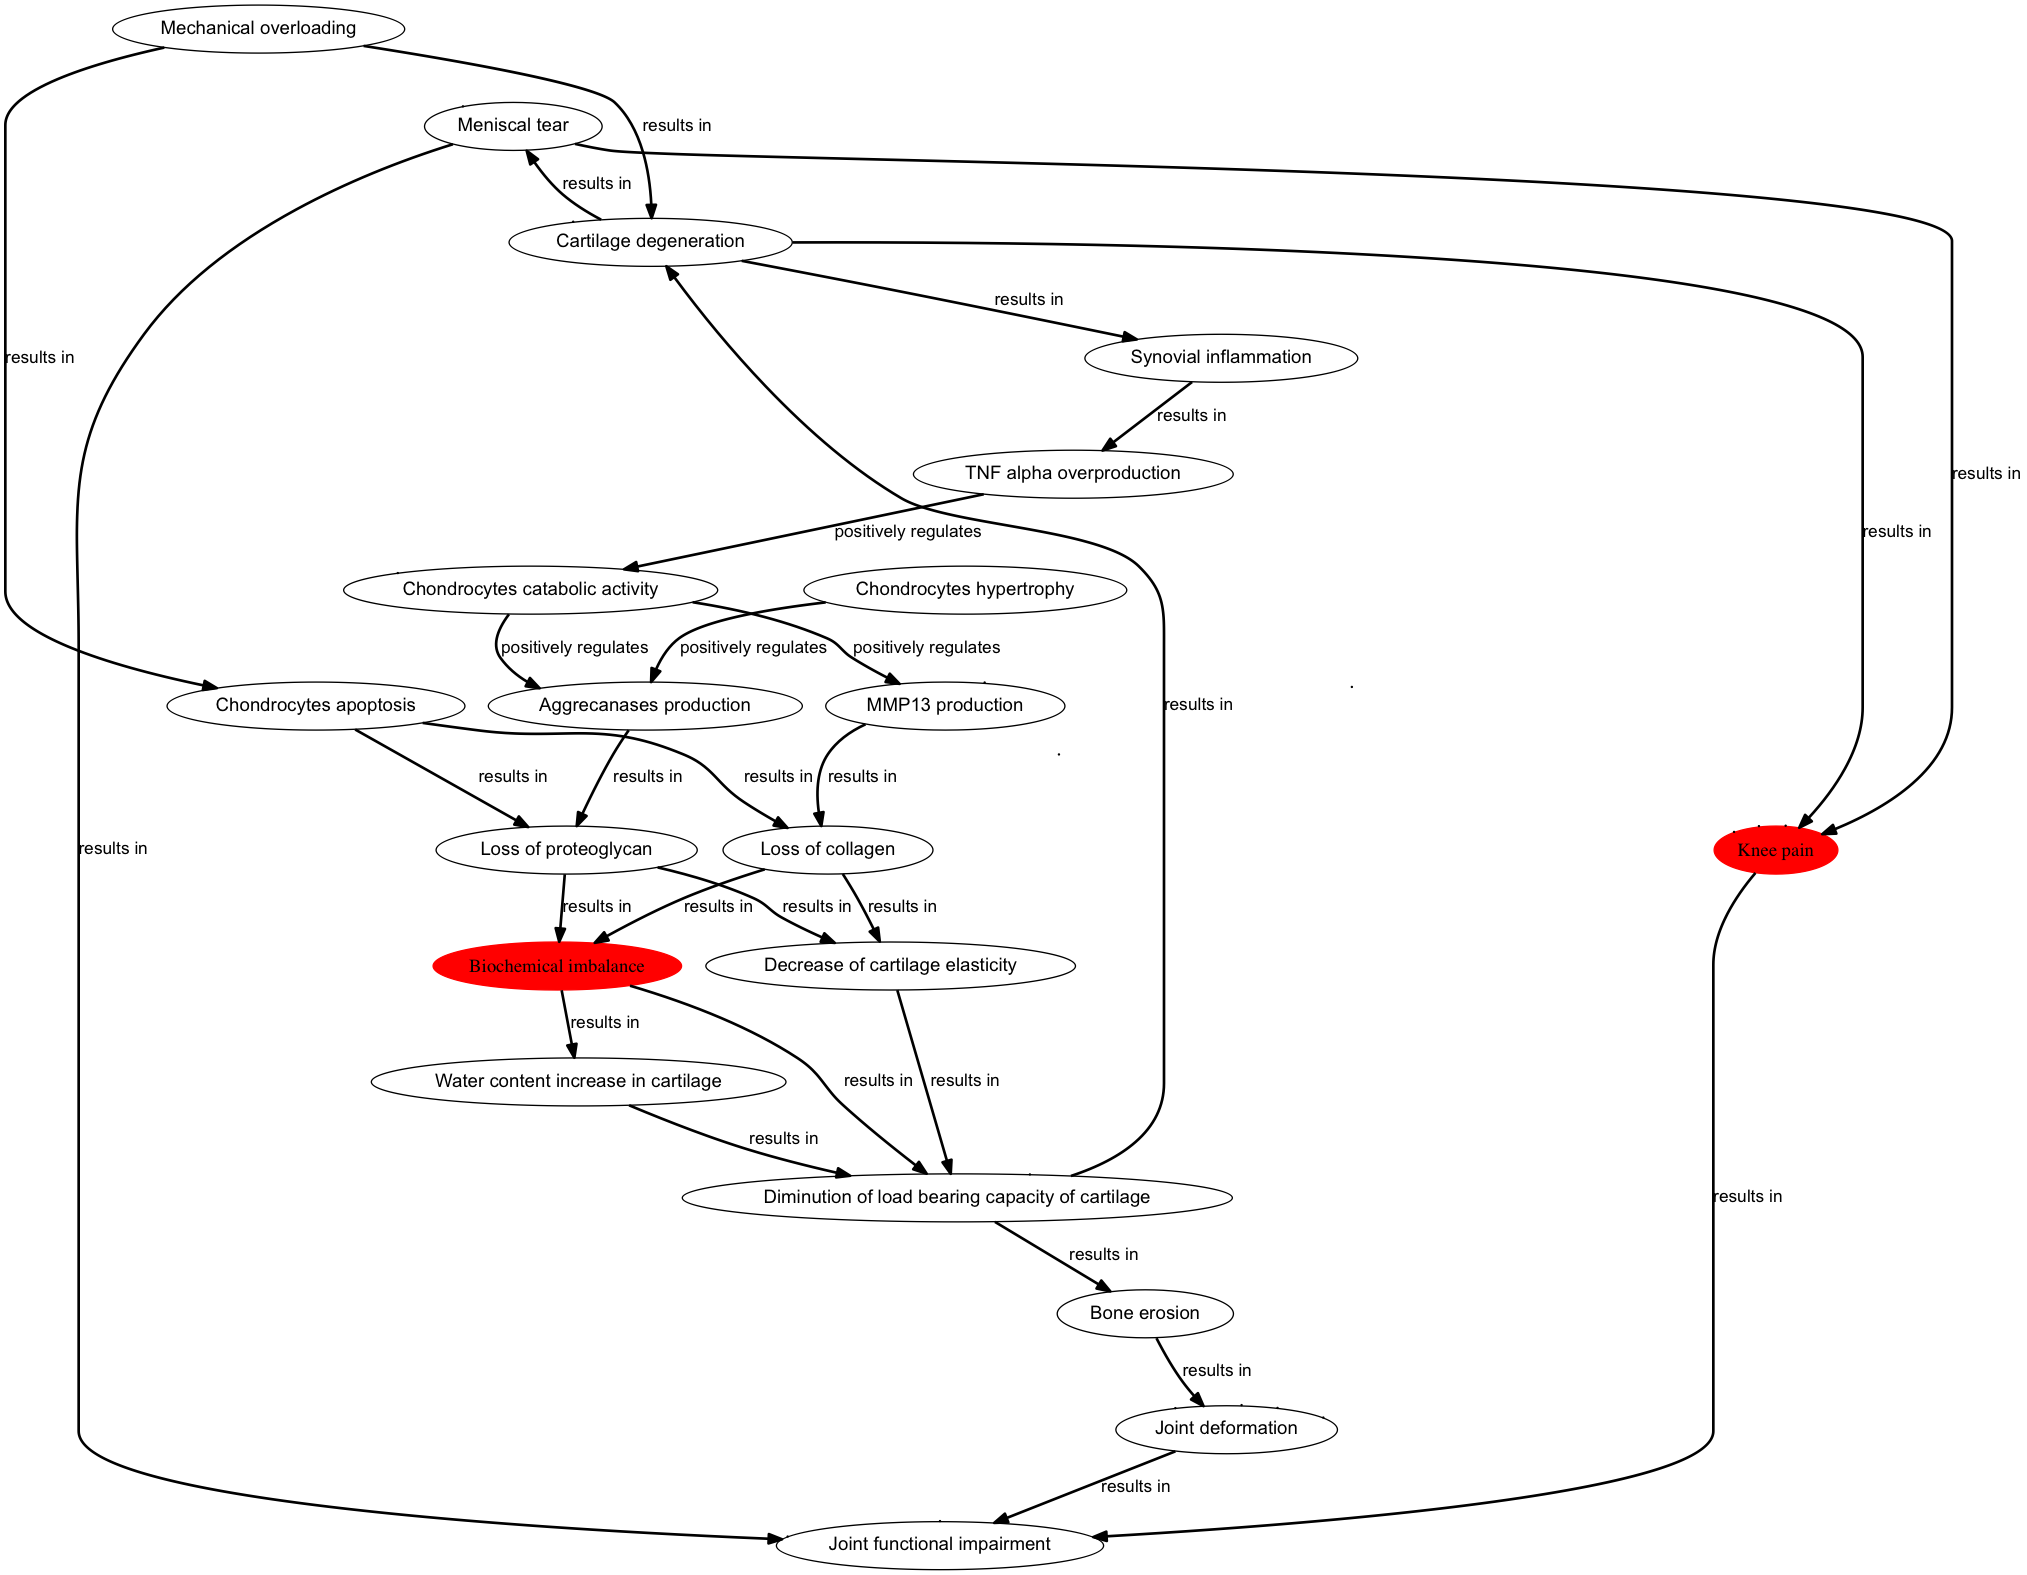

In [42]:
Image(small_png)

### Draw big graph

In [43]:
big_dot = os.path.join(path_to_figures, 'big.dot')
big_png = os.path.join(path_to_figures, 'big.png')

with open(big_dot, 'w') as f:
    write_dot.hypothgraph_to_dot(hypothgraph, conf, stream=f)

In [44]:
!dot -Tpng -o $big_png $big_dot

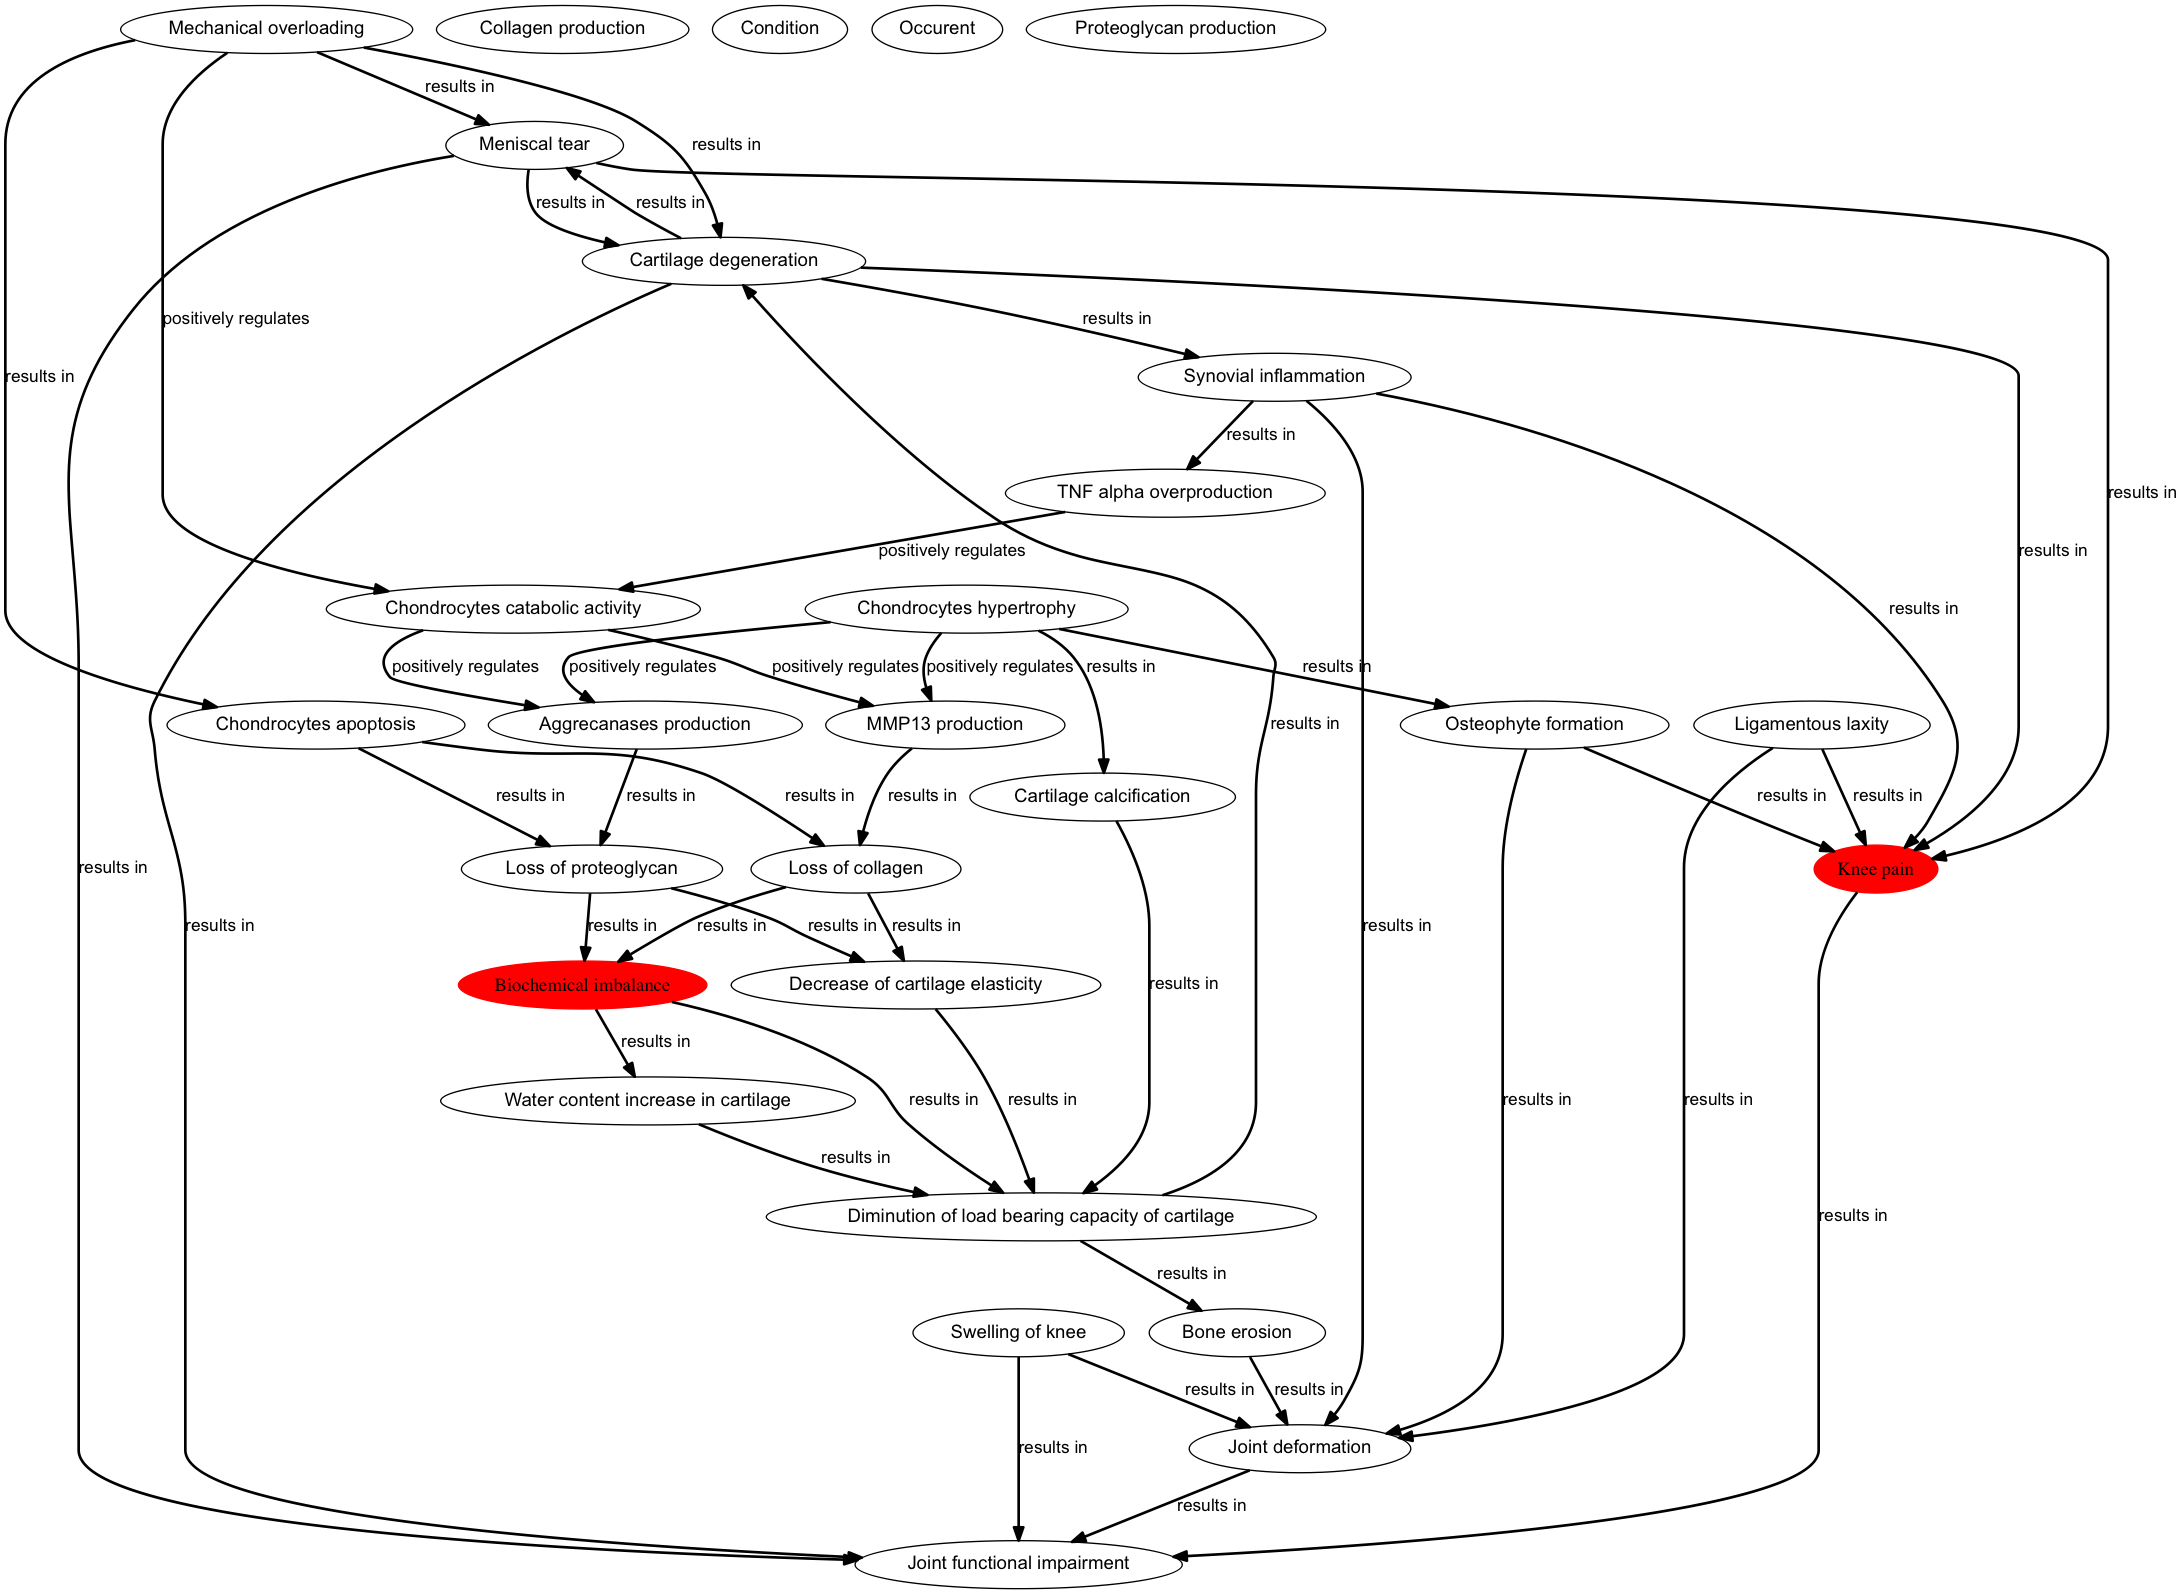

In [45]:
Image(big_png)

### Draw superimposed

In [46]:
superimposed_dot = os.path.join(path_to_figures, 'superimposed.dot')
superimposed_png = os.path.join(path_to_figures, 'superimposed.png')

with open(superimposed_dot, 'w') as f:
    write_dot.big_small_to_dot(hypothgraph, subgraph, conf, stream=f)

In [47]:
!dot -Tpng -o $superimposed_png $superimposed_dot

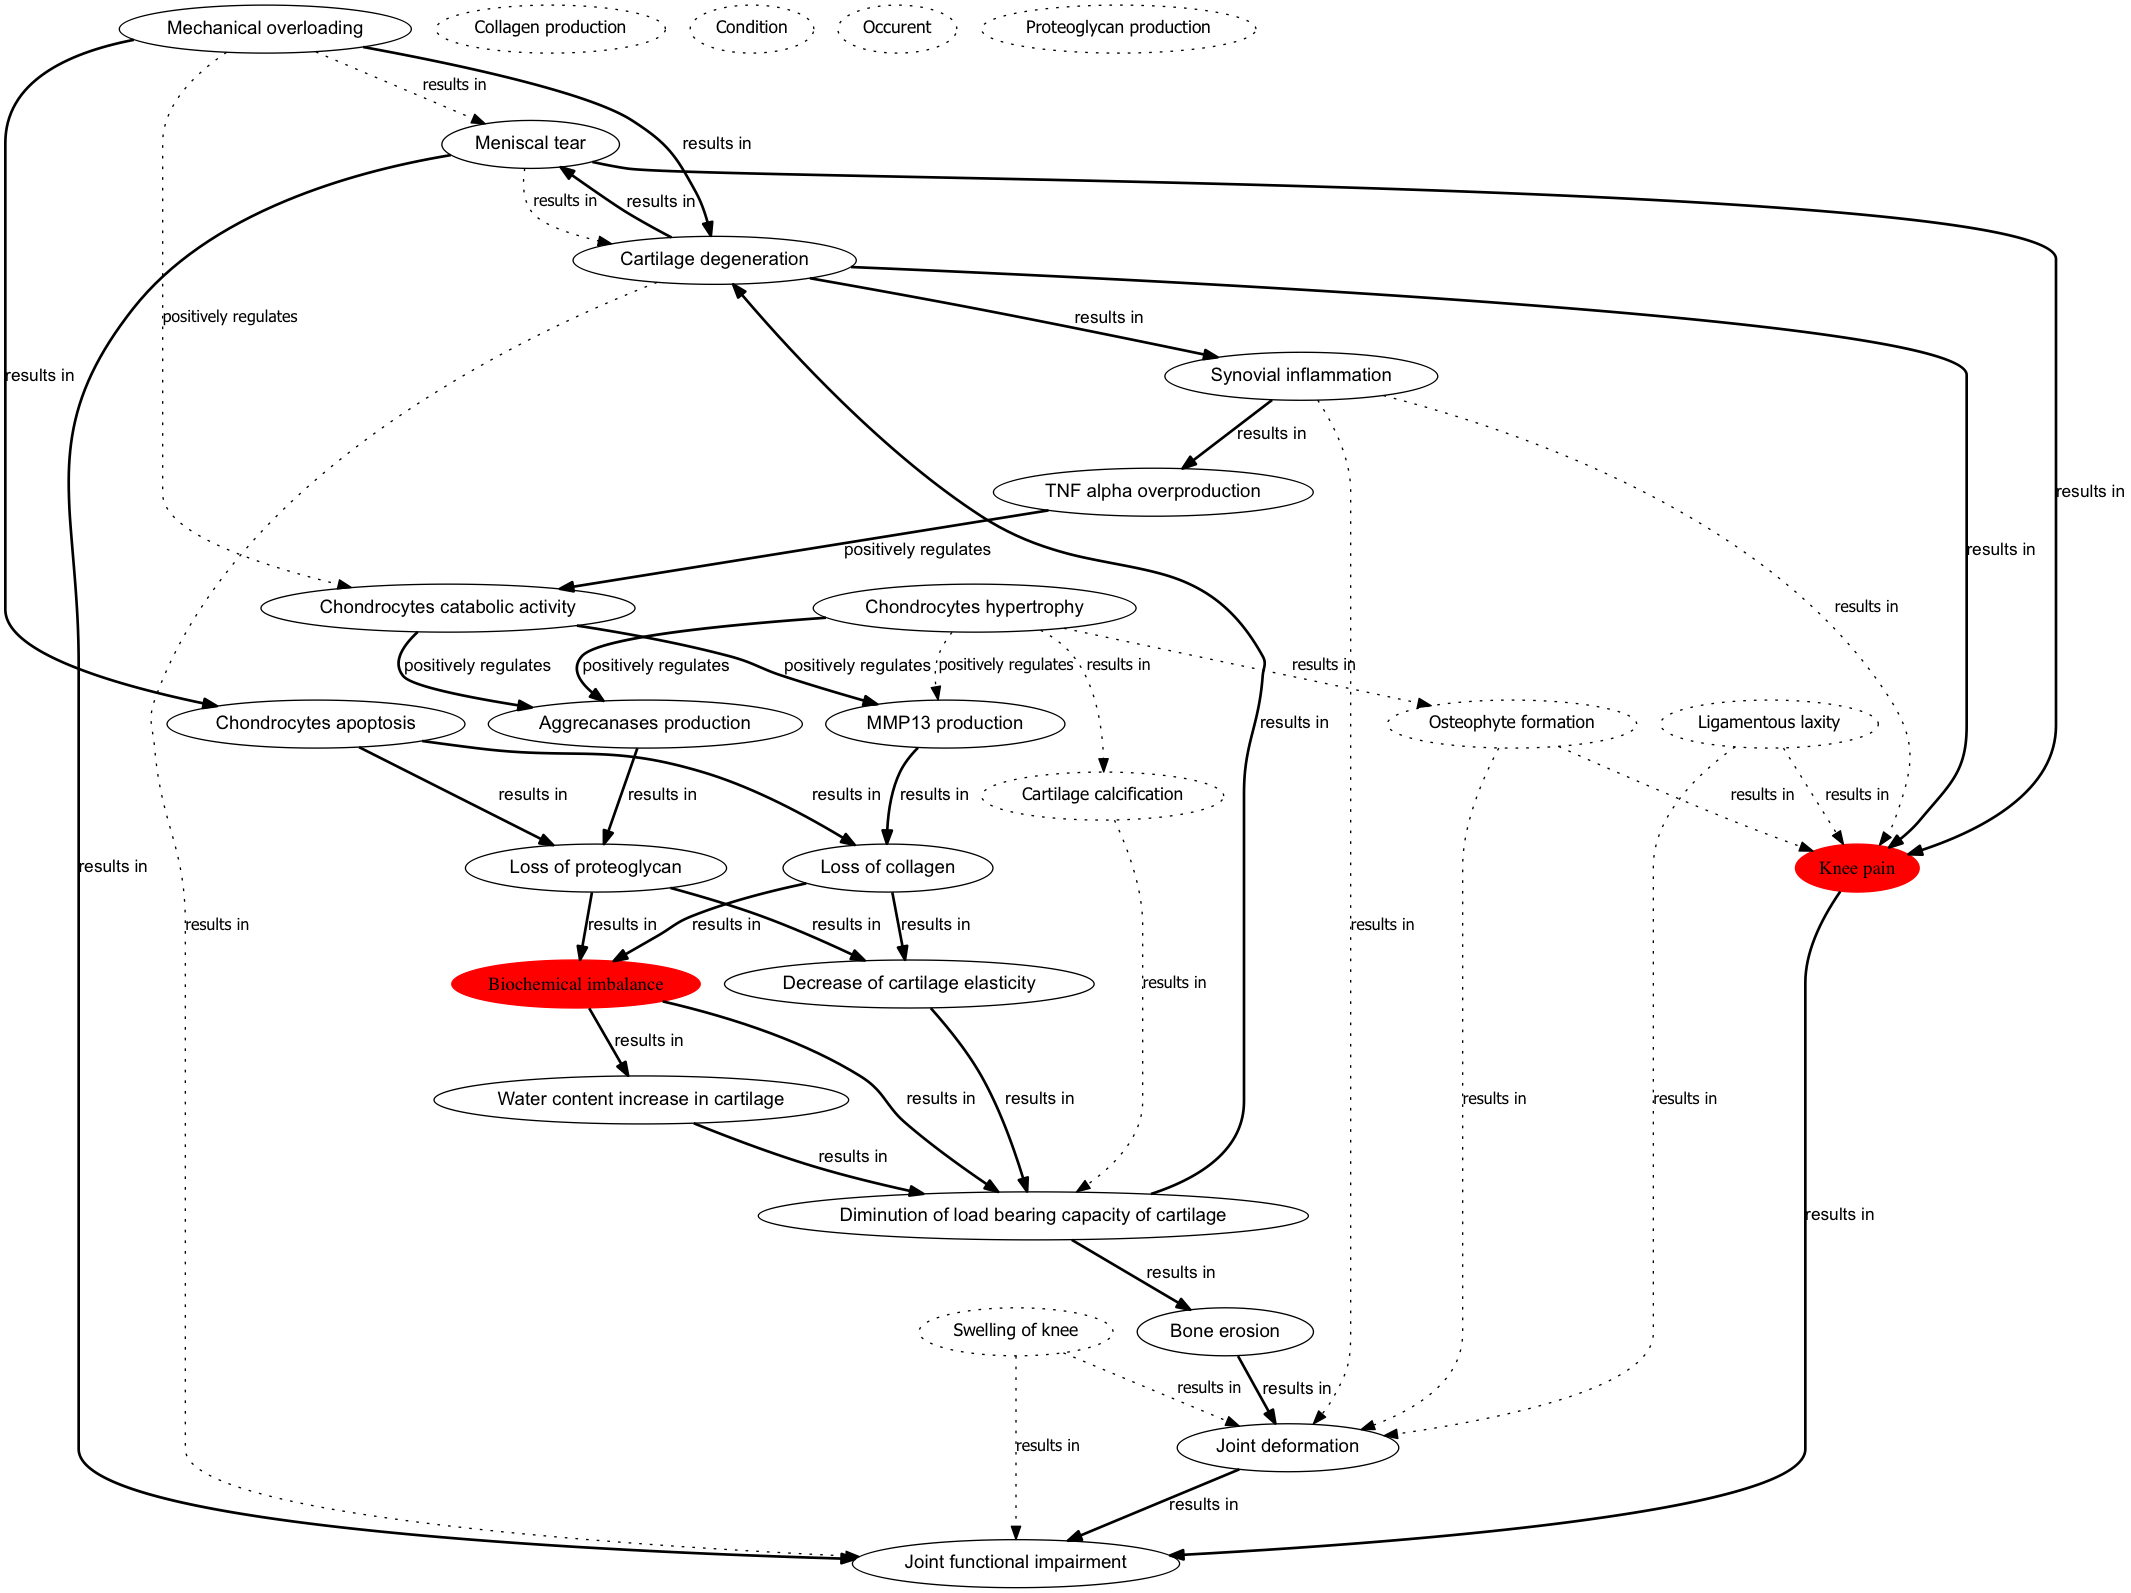

In [48]:
Image(superimposed_png)